#### Library imports

In [1]:
import rasterio
import seaborn as sns
from shapely import wkt
import pandas as pd
from numpy import nan as np_nan
from os import makedirs

import utilities as utils

#### Loads the raw datacube

In [2]:
data = utils.load_dataset("data/LAWLEY22-DATACUBE/2021_Table04_Datacube.csv")
data.head()

ï»¿"H3_Address"  H3_Resolution  \
0  8712e579bffffff              7   
1  8712e579affffff              7   
2  8712e56b4ffffff              7   
3  8712e56b5ffffff              7   
4  8712e56a6ffffff              7   

                                         H3_Geometry  Longitude_EPSG4326  \
0  POLYGON ((-115.0314 54.5077, -115.0393 54.4961...         -115.018142   
1  POLYGON ((-115.0658 54.51706, -115.0737 54.505...         -115.052542   
2  POLYGON ((-115.0604 54.49501, -115.0682 54.483...         -115.047107   
3  POLYGON ((-115.026 54.48564, -115.0338 54.4740...         -115.012729   
4  POLYGON ((-114.997 54.49832, -115.0049 54.4867...         -114.983753   

   Latitude_EPSG4326 Continent_Majority Continent_Minority Country_Majority  \
0          54.497221      North America      North America           Canada   
1          54.506590      North America      North America           Canada   
2          54.484541      North America      North America           Canada   
3          54.475169      North America      North America           Canada   
4          54.487840      North America      North America           Canada   

  Country_Minority Province_Majority  ... Litmod_Density_Asthenosphere  \
0           Canada           Alberta  ...                  3480.580078   
1           Canada           Alberta  ...                  3480.580078   
2           Canada           Alberta  ...                  3480.580078   
3           Canada           Alberta  ...                  3480.580078   
4           Canada           Alberta  ...                  3480.580078   

  Litmod_Density_Crust Litmod_Density_Lithosphere Crust1_Type  \
0          2891.260254                3337.300049  island arc   
1          2891.260010                3337.300293  island arc   
2          2891.259766                3337.300049  island arc   
3          2891.260010                3337.300049  island arc   
4          2891.260010                3337.300049  island arc   

   Crust1_CrustalThickness Crust1_SedimentThickness Training_MVT_Deposit  \
0               -38.450497              2991.459961               Absent   
1               -38.430000              3000.000244               Absent   
2               -38.430000              3000.000000               Absent   
3               -38.591599              2932.666504               Absent   
4               -39.815273              2422.801758               Absent   

  Training_MVT_Occurrence Training_CD_Deposit Training_CD_Occurrence  
0                  Absent              Absent                 Absent  
1                  Absent              Absent                 Absent  
2                  Absent              Absent                 Absent  
3                  Absent              Absent                 Absent  
4                  Absent              Absent                 Absent  

[5 rows x 97 columns]

### Modifies presence / absence columns to boolean - geology properties

In [3]:
# modifies presence / absence columns to boolean - geology properties
data["Geology_Dictionary_Alkalic"] = data["Geology_Dictionary_Alkalic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Anatectic"] = data["Geology_Dictionary_Anatectic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Calcareous"] = data["Geology_Dictionary_Calcareous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Carbonaceous"] = data["Geology_Dictionary_Carbonaceous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Cherty"] = data["Geology_Dictionary_Cherty"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_CoarseClastic"] = data["Geology_Dictionary_CoarseClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Evaporitic"] = data["Geology_Dictionary_Evaporitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Felsic"] = data["Geology_Dictionary_Felsic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_FineClastic"] = data["Geology_Dictionary_FineClastic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Gneissose"] = data["Geology_Dictionary_Gneissose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Igneous"] = data["Geology_Dictionary_Igneous"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Intermediate"] = data["Geology_Dictionary_Intermediate"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Pegmatitic"] = data["Geology_Dictionary_Pegmatitic"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_RedBed"] = data["Geology_Dictionary_RedBed"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Schistose"] = data["Geology_Dictionary_Schistose"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_Sedimentary"] = data["Geology_Dictionary_Sedimentary"].apply(lambda x: True if x == "Present" else False)
data["Geology_Dictionary_UltramaficMafic"] = data["Geology_Dictionary_UltramaficMafic"].apply(lambda x: True if x == "Present" else False)
# modifies presence / absence columns to boolean - labels
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

#### Selects the input variable data used for MVT GBM preferred (i.e. all input variables)

In [4]:
cols_dict = utils.load_features_dict(deptype='MVT', baseline='preferred')
data_filtered, cols = utils.extract_cols(data, cols_dict)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 29 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   H3_Geometry                                     object 
 1   Continent_Majority                              object 
 2   Latitude_EPSG4326                               float64
 3   Geology_Lithology_Majority                      object 
 4   Geology_Lithology_Minority                      object 
 5   Geology_Period_Maximum_Majority                 object 
 6   Geology_Period_Minimum_Majority                 object 
 7   Sedimentary_Dictionary                          bool   
 8   Igneous_Dictionary                              bool   
 9   Metamorphic_Dictionary                          bool   
 10  Seismic_LAB_Priestley                           float64
 11  Seismic_Moho                                    float64
 12  Gravity_GOCE_ShapeIndex     

#### Splits the data across continents for improved preprocessing

In [5]:

data_filtered_aus = data_filtered[data_filtered["Continent_Majority"] == "Oceania"]
data_filtered_uscan = data_filtered[data_filtered["Continent_Majority"] == "North America"]

#### Selects target variable data used for GBM preferred
The following function finds all the neighbors and creates a new column "MVT_Deposit". Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor).

In [6]:
data_filtered_aus = utils.neighbor_deposits(data_filtered_aus, deptype='MVT')
print(data_filtered_aus['Training_MVT_Deposit'].value_counts())
data_filtered_uscan = utils.neighbor_deposits(data_filtered_uscan, deptype='MVT')
print(data_filtered_uscan['Training_MVT_Deposit'].value_counts())

/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{deptype}_Deposit'] = df.apply(lambda row: True if True in [row[f'Training_{deptype}_Deposit'], row[f'Training_{deptype}_Occurrence']] else False, axis=1)
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:

Training_MVT_Deposit
False    1544765
True          46
Name: count, dtype: int64


/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{deptype}_Deposit'] = df.apply(lambda row: True if True in [row[f'Training_{deptype}_Deposit'], row[f'Training_{deptype}_Occurrence']] else False, axis=1)
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['H3_Geometry2'] = df['H3_Geometry'].apply(lambda x: x[10:-2].split(', ')[:-1])
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:

Training_MVT_Deposit
False    3619855
True         167
Name: count, dtype: int64


#### Implements GBM preferred preprocessing on datacube

In [7]:
labels_filtered_aus = data_filtered_aus['MVT_Deposit'] # store target for later use
dep_filtered_aus = data_filtered_aus['Training_MVT_Deposit'] # store split column for later use
geometry_filtered_aus = data_filtered_aus["H3_Geometry"] # store polygons for later use
continent_filtered_aus = data_filtered_aus["Continent_Majority"] # store continent for later use

labels_filtered_uscan = data_filtered_uscan['MVT_Deposit'] # store target for later use
dep_filtered_uscan = data_filtered_uscan['Training_MVT_Deposit'] # store split column for later use
geometry_filtered_uscan = data_filtered_uscan["H3_Geometry"] # store polygons for later use
continent_filtered_uscan = data_filtered_uscan["Continent_Majority"] # store continent for later use

data_filtered_aus = data_filtered_aus.drop(columns=['H3_Geometry', 'Continent_Majority', 'Latitude_EPSG4326', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
data_filtered_uscan = data_filtered_uscan.drop(columns=['H3_Geometry', 'Continent_Majority', 'Latitude_EPSG4326', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
cols = cols[3:-2]

Clearly the dataset has MANY outliers, as reported in the paper

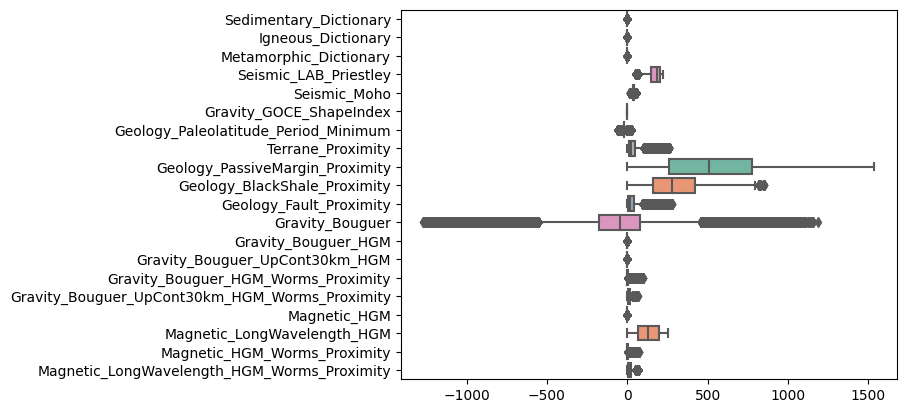

In [8]:
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

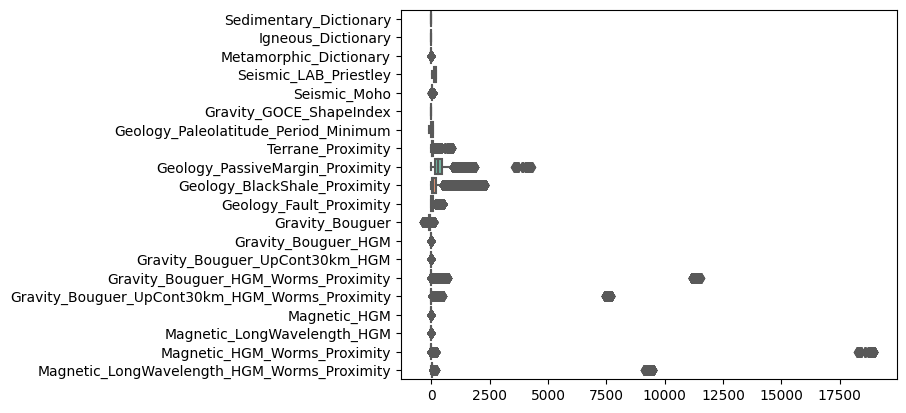

In [9]:
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

We can remove these outliers

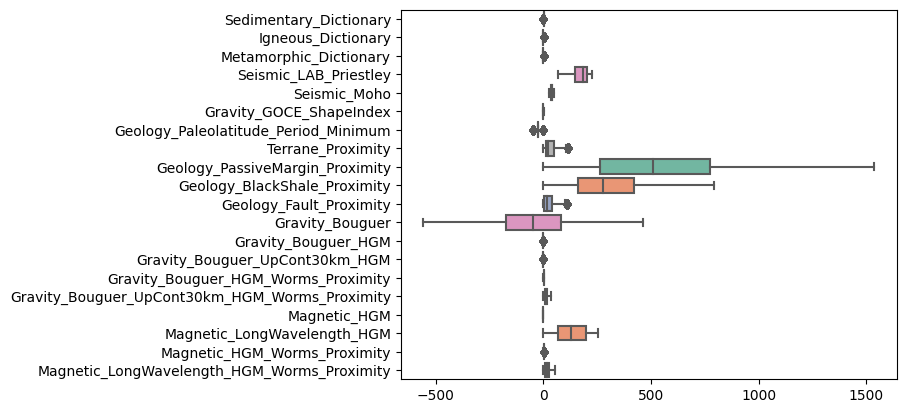

In [10]:
data_filtered_aus = utils.tukey_remove_outliers(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")

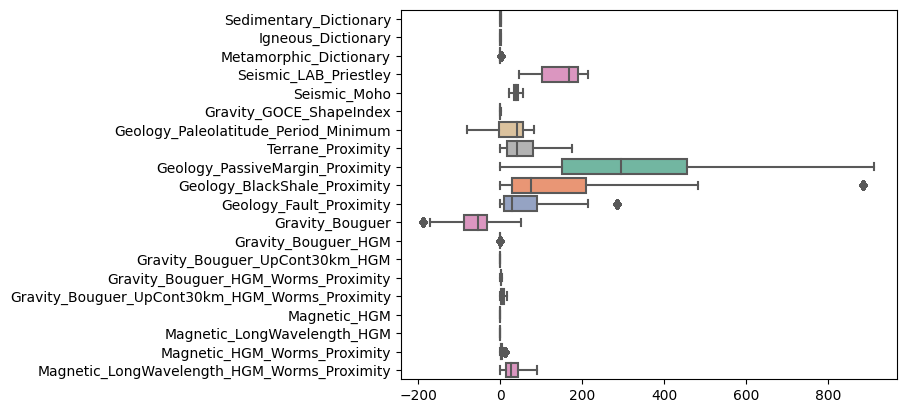

In [11]:
data_filtered_uscan = utils.tukey_remove_outliers(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [12]:
print(data_filtered_aus.isna().sum())

Geology_Lithology_Majority                             0
Geology_Lithology_Minority                             0
Geology_Period_Maximum_Majority                        0
Geology_Period_Minimum_Majority                        0
Sedimentary_Dictionary                                 0
Igneous_Dictionary                                     0
Metamorphic_Dictionary                                 0
Seismic_LAB_Priestley                                  0
Seismic_Moho                                           0
Gravity_GOCE_ShapeIndex                                0
Geology_Paleolatitude_Period_Minimum              154947
Terrane_Proximity                                      0
Geology_PassiveMargin_Proximity                        0
Geology_BlackShale_Proximity                           0
Geology_Fault_Proximity                                0
Gravity_Bouguer                                        0
Gravity_Bouguer_HGM                                    0
Gravity_Bouguer_UpCont30km_HGM 

In [13]:
print(data_filtered_uscan.isna().sum())

Geology_Lithology_Majority                             0
Geology_Lithology_Minority                           410
Geology_Period_Maximum_Majority                    44289
Geology_Period_Minimum_Majority                    44289
Sedimentary_Dictionary                                 0
Igneous_Dictionary                                     0
Metamorphic_Dictionary                                 0
Seismic_LAB_Priestley                                  0
Seismic_Moho                                        1266
Gravity_GOCE_ShapeIndex                                0
Geology_Paleolatitude_Period_Minimum              884529
Terrane_Proximity                                      0
Geology_PassiveMargin_Proximity                        0
Geology_BlackShale_Proximity                           0
Geology_Fault_Proximity                                0
Gravity_Bouguer                                    36359
Gravity_Bouguer_HGM                                36403
Gravity_Bouguer_UpCont30km_HGM 

In [14]:
data_filtered_aus = utils.impute_nans(data_filtered_aus)
print(data_filtered_aus.isna().sum())

Geology_Lithology_Majority                        0
Geology_Lithology_Minority                        0
Geology_Period_Maximum_Majority                   0
Geology_Period_Minimum_Majority                   0
Sedimentary_Dictionary                            0
Igneous_Dictionary                                0
Metamorphic_Dictionary                            0
Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Geology_Paleolatitude_Period_Minimum              0
Terrane_Proximity                                 0
Geology_PassiveMargin_Proximity                   0
Geology_BlackShale_Proximity                      0
Geology_Fault_Proximity                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Boug

In [15]:
data_filtered_uscan = utils.impute_nans(data_filtered_uscan)
print(data_filtered_uscan.isna().sum())

Geology_Lithology_Majority                        0
Geology_Lithology_Minority                        0
Geology_Period_Maximum_Majority                   0
Geology_Period_Minimum_Majority                   0
Sedimentary_Dictionary                            0
Igneous_Dictionary                                0
Metamorphic_Dictionary                            0
Seismic_LAB_Priestley                             0
Seismic_Moho                                      0
Gravity_GOCE_ShapeIndex                           0
Geology_Paleolatitude_Period_Minimum              0
Terrane_Proximity                                 0
Geology_PassiveMargin_Proximity                   0
Geology_BlackShale_Proximity                      0
Geology_Fault_Proximity                           0
Gravity_Bouguer                                   0
Gravity_Bouguer_HGM                               0
Gravity_Bouguer_UpCont30km_HGM                    0
Gravity_Bouguer_HGM_Worms_Proximity               0
Gravity_Boug

Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


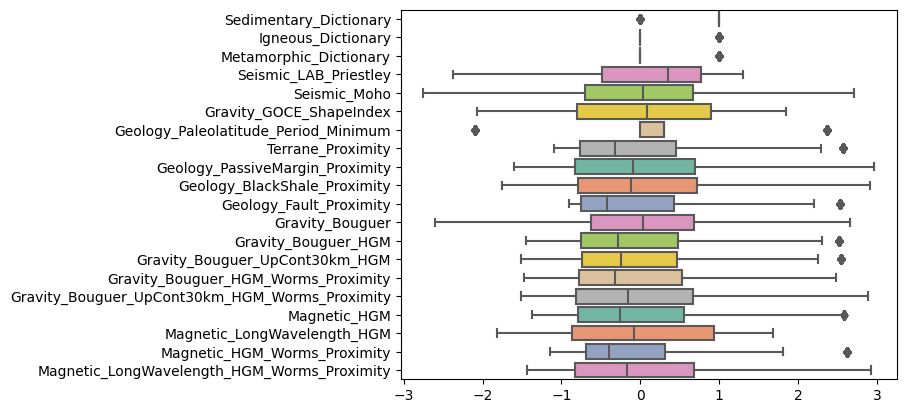

In [16]:
data_filtered_aus = utils.normalize_df(data_filtered_aus)
ax = sns.boxplot(data=data_filtered_aus, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

(note remaining outliers above were within the Tukey fences calculated over ALL the data)


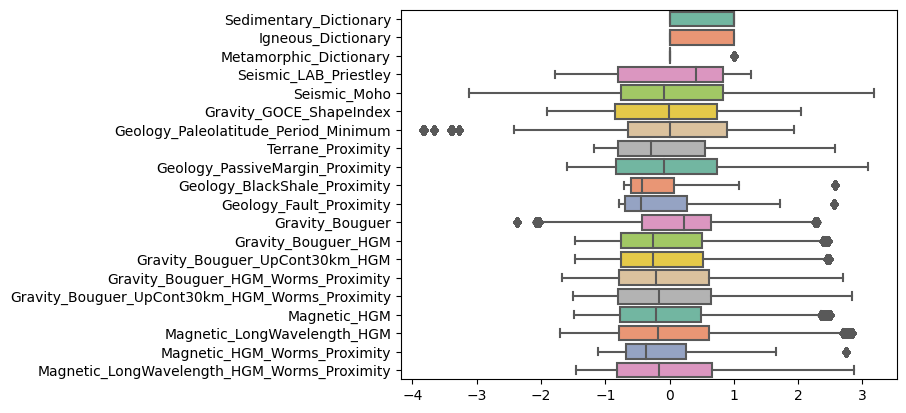

In [17]:
data_filtered_uscan = utils.normalize_df(data_filtered_uscan)
ax = sns.boxplot(data=data_filtered_uscan, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

#### Preprocessing completed, the data is prepared for output

In [18]:
data_filtered_aus["target"] = labels_filtered_aus
data_filtered_aus["H3_Geometry"] = geometry_filtered_aus
data_filtered_aus["Continent_Majority"] = continent_filtered_aus
data_filtered_aus["Training_MVT_Deposit"] = dep_filtered_aus

data_filtered_uscan["target"] = labels_filtered_uscan
data_filtered_uscan["H3_Geometry"] = geometry_filtered_uscan
data_filtered_uscan["Continent_Majority"] = continent_filtered_uscan
data_filtered_uscan["Training_MVT_Deposit"] = dep_filtered_uscan

# concatenates the separate datacubes into a single one
data_filtered = pd.concat((data_filtered_aus, data_filtered_uscan), ignore_index=True)
data_filtered.reset_index(drop=True, inplace=True)
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164833 entries, 0 to 5164832
Data columns (total 28 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   Geology_Lithology_Majority                      object 
 1   Geology_Lithology_Minority                      object 
 2   Geology_Period_Maximum_Majority                 object 
 3   Geology_Period_Minimum_Majority                 object 
 4   Sedimentary_Dictionary                          bool   
 5   Igneous_Dictionary                              bool   
 6   Metamorphic_Dictionary                          bool   
 7   Seismic_LAB_Priestley                           float64
 8   Seismic_Moho                                    float64
 9   Gravity_GOCE_ShapeIndex                         float64
 10  Geology_Paleolatitude_Period_Minimum            float64
 11  Terrane_Proximity                               float64
 12  Geology_PassiveMargin_Proxim

#### Generates tiff files for every column, separate for US/Canada and Australia

Rasterizing Oceania


/tmp/ipykernel_11505/1603532246.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube["H3_Geometry"] = continent_datacube["H3_Geometry"].apply(wkt.loads)
/tmp/ipykernel_11505/1603532246.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({


Plotting - ['Lithology (major)', 'Lithology (minor)', 'Period (maximum)', 'Period (minimum)', 'Sedimentary dictionaries', 'Igneous dictionaries', 'Metamorphic dictionaries', 'Depth to Lab', 'Depth to Moho', 'Satellite Gravity', 'Geology_Paleolatitude_Period_Minimum', 'Proximity to terrane boundaries', 'Proximity to passive margins', 'Proximity to black shales', 'Proximity to faults', 'Gravity Bouguer', 'Gravity HGM', 'Gravity upward-continued HGM', 'Gravity Worms', 'Gravity upward-continued worms', 'Magnetic HGM', 'Magnetic long-wavelength HGM', 'Magnetic worms', 'Magnetic long-wavelength worms', 'target', 'Training_MVT_Deposit']


  0%|          | 0/26 [00:00<?, ?it/s]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


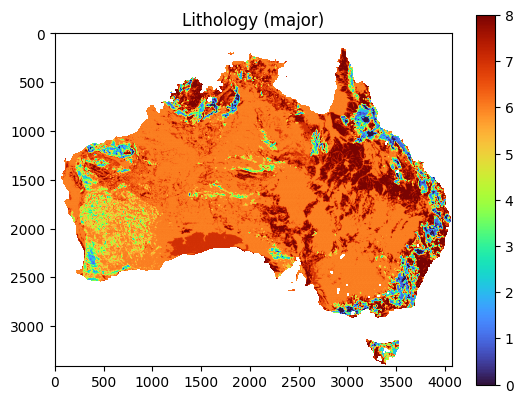

  4%|▍         | 1/26 [01:16<31:48, 76.34s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


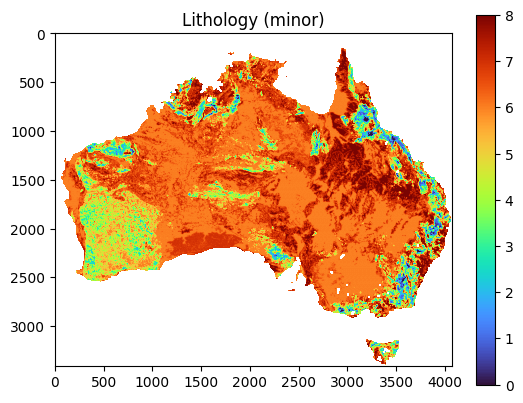

  8%|▊         | 2/26 [02:32<30:33, 76.38s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


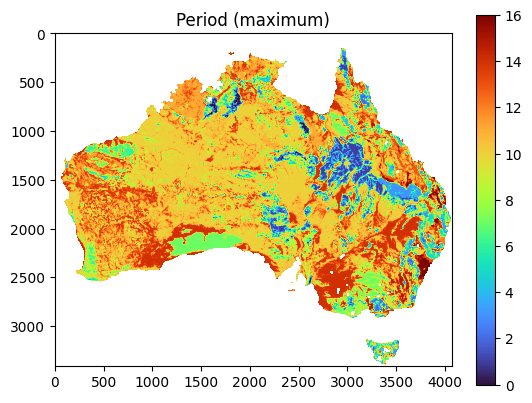

 12%|█▏        | 3/26 [03:49<29:22, 76.64s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


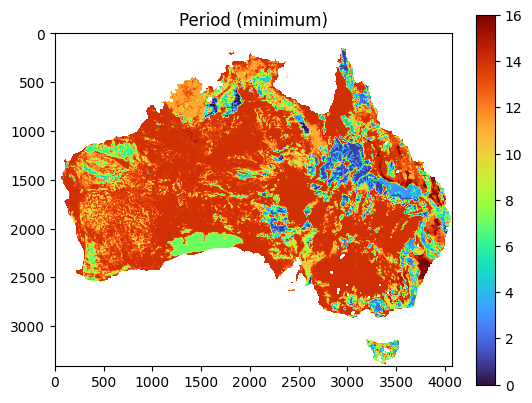

 15%|█▌        | 4/26 [05:07<28:18, 77.23s/it]

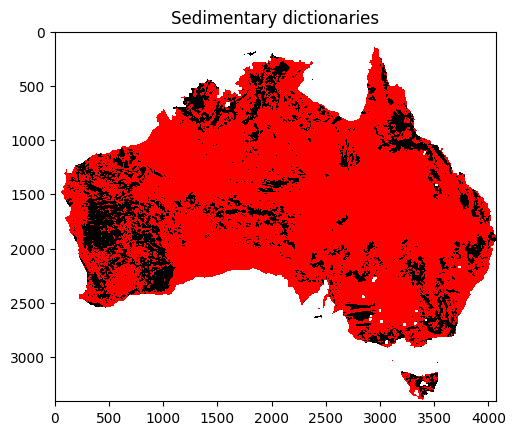

 19%|█▉        | 5/26 [06:23<26:52, 76.80s/it]

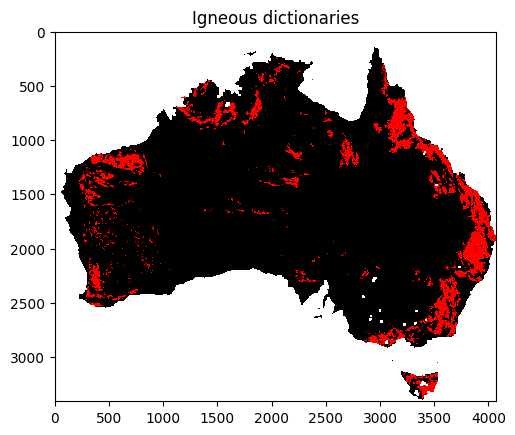

 23%|██▎       | 6/26 [07:39<25:27, 76.38s/it]

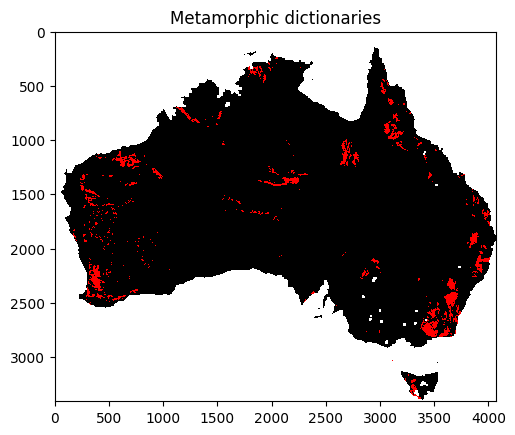

 27%|██▋       | 7/26 [08:54<24:05, 76.09s/it]

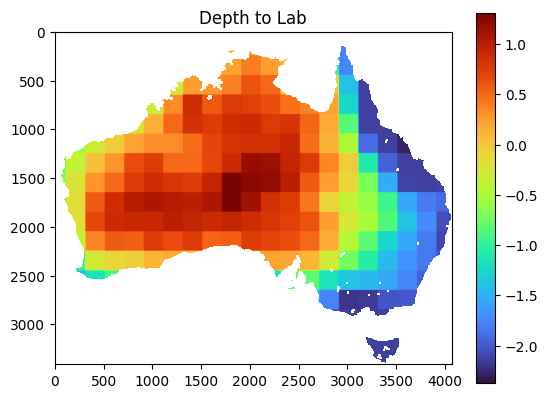

 31%|███       | 8/26 [10:11<22:51, 76.20s/it]

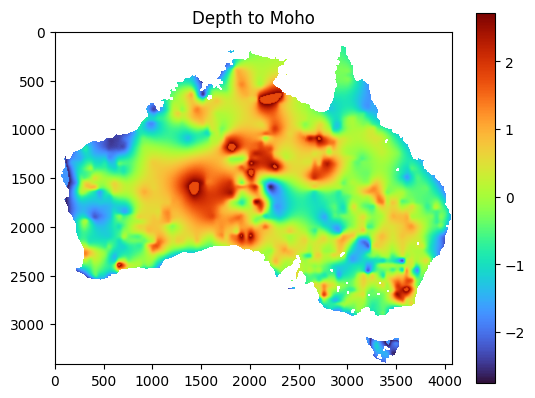

 35%|███▍      | 9/26 [11:27<21:34, 76.14s/it]

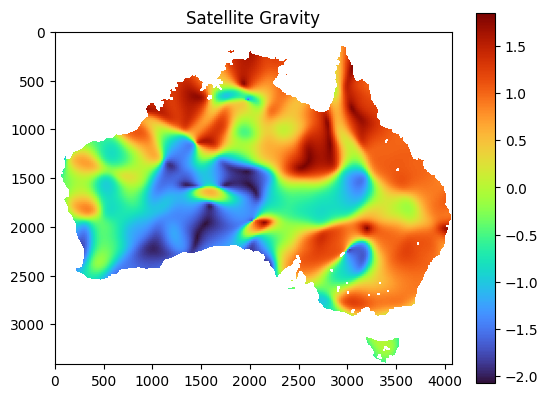

 38%|███▊      | 10/26 [12:43<20:16, 76.00s/it]

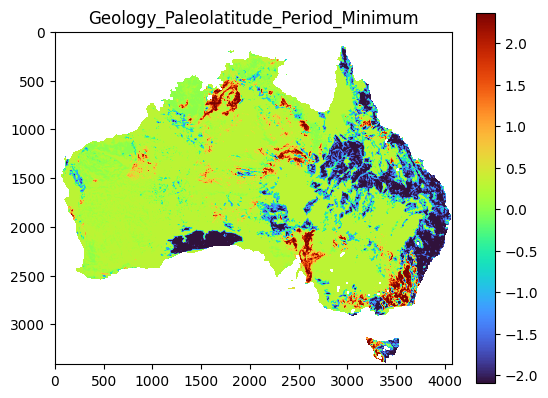

 42%|████▏     | 11/26 [13:59<19:02, 76.17s/it]

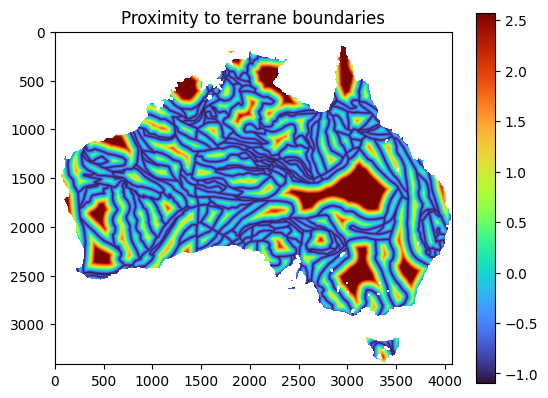

 46%|████▌     | 12/26 [15:15<17:45, 76.10s/it]

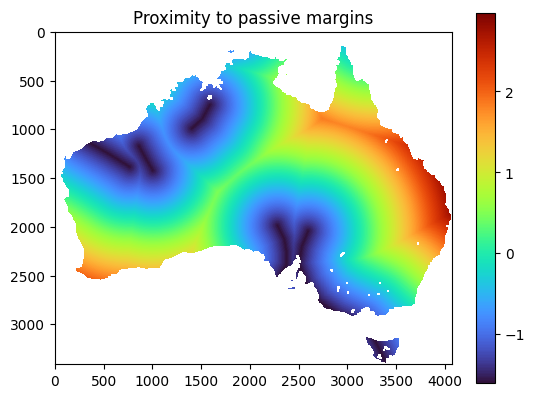

 50%|█████     | 13/26 [16:30<16:25, 75.83s/it]

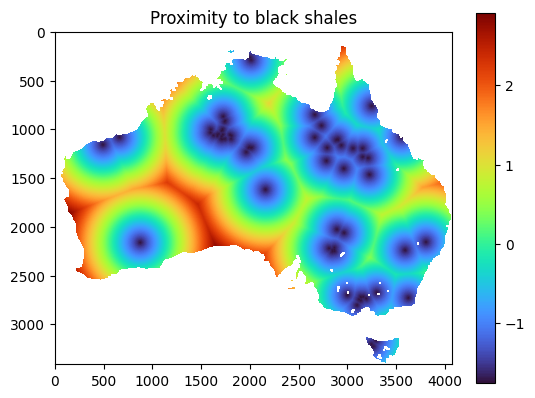

 54%|█████▍    | 14/26 [17:46<15:08, 75.75s/it]

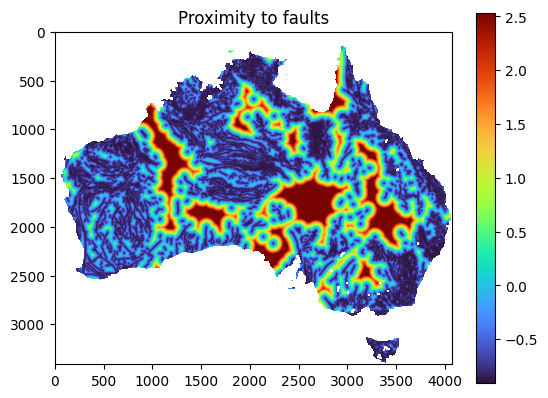

 58%|█████▊    | 15/26 [19:01<13:51, 75.55s/it]

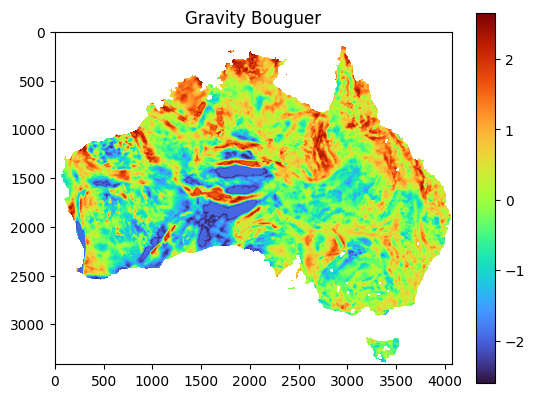

 62%|██████▏   | 16/26 [20:17<12:35, 75.58s/it]

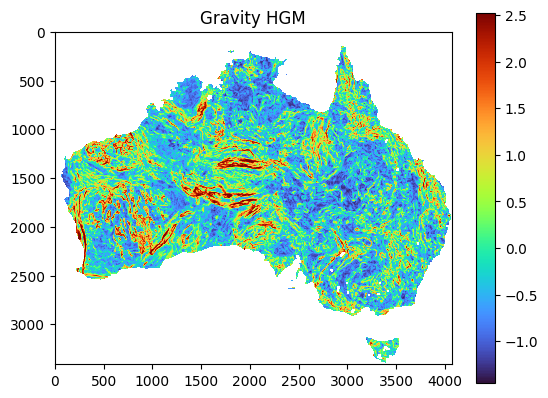

 65%|██████▌   | 17/26 [21:33<11:21, 75.71s/it]

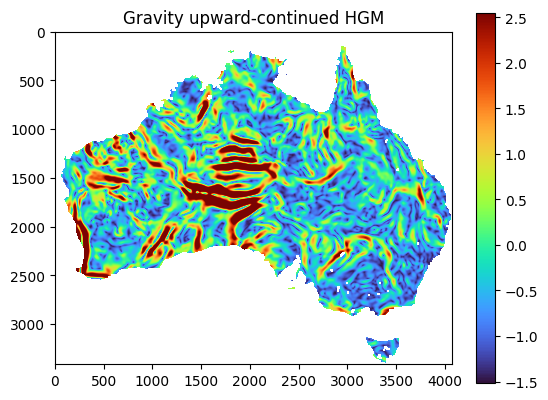

 69%|██████▉   | 18/26 [22:49<10:07, 75.90s/it]

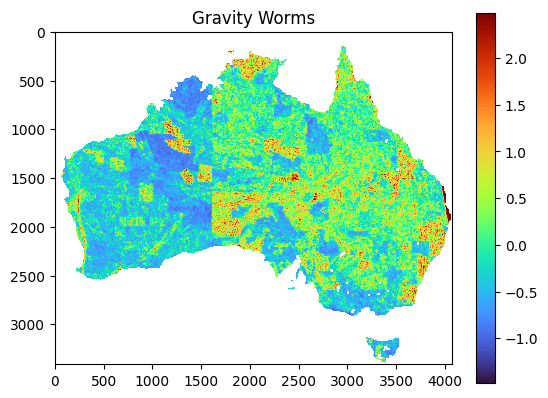

 73%|███████▎  | 19/26 [24:05<08:52, 76.02s/it]

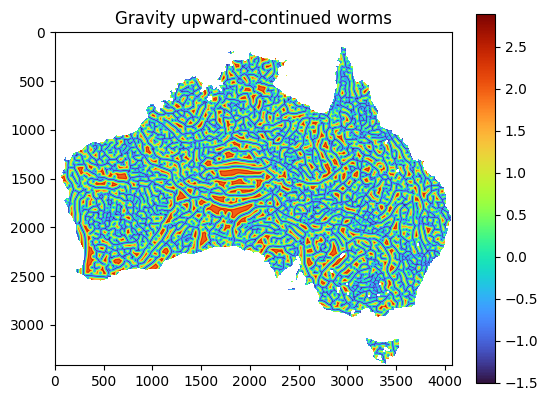

 77%|███████▋  | 20/26 [25:21<07:35, 75.87s/it]

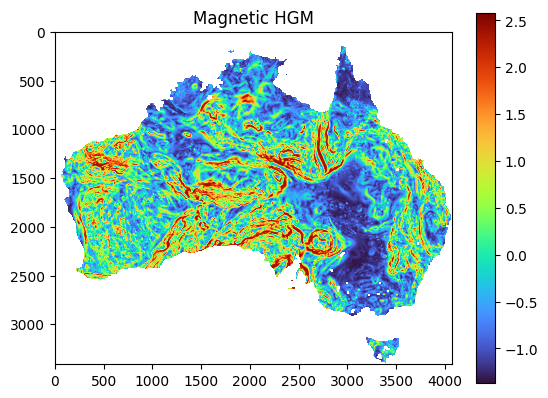

 81%|████████  | 21/26 [26:37<06:19, 75.88s/it]

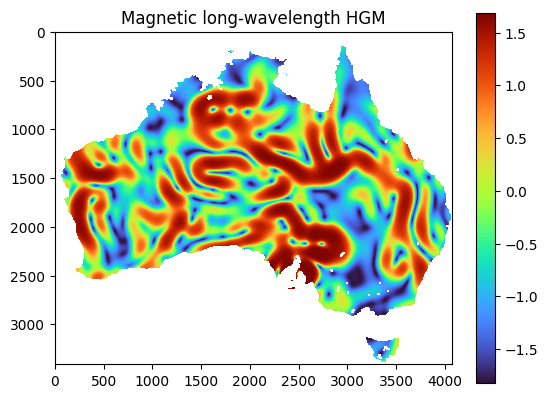

 85%|████████▍ | 22/26 [27:52<05:03, 75.84s/it]

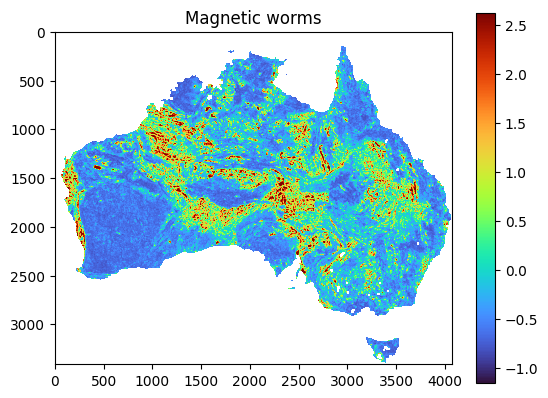

 88%|████████▊ | 23/26 [29:09<03:48, 76.01s/it]

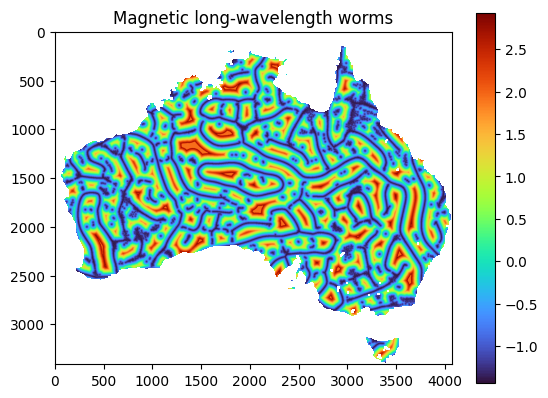

 92%|█████████▏| 24/26 [30:25<02:32, 76.01s/it]

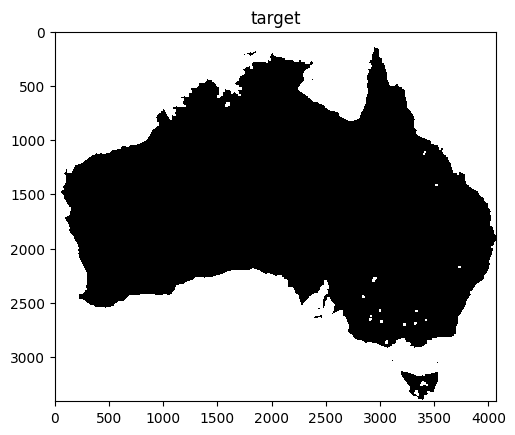

 96%|█████████▌| 25/26 [31:41<01:16, 76.00s/it]

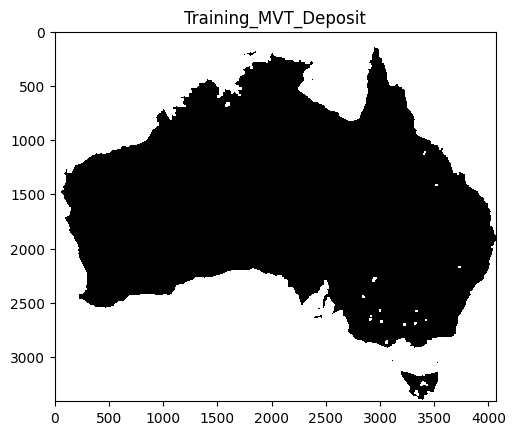

100%|██████████| 26/26 [32:56<00:00, 76.01s/it]


Outputting - ['Sedimentary dictionaries', 'Igneous dictionaries', 'Metamorphic dictionaries', 'Depth to Lab', 'Depth to Moho', 'Satellite Gravity', 'Geology_Paleolatitude_Period_Minimum', 'Proximity to terrane boundaries', 'Proximity to passive margins', 'Proximity to black shales', 'Proximity to faults', 'Gravity Bouguer', 'Gravity HGM', 'Gravity upward-continued HGM', 'Gravity Worms', 'Gravity upward-continued worms', 'Magnetic HGM', 'Magnetic long-wavelength HGM', 'Magnetic worms', 'Magnetic long-wavelength worms', 'Training_MVT_Deposit', 'Lithology (major)_0', 'Lithology (major)_1', 'Lithology (major)_2', 'Lithology (major)_3', 'Lithology (major)_4', 'Lithology (major)_5', 'Lithology (major)_6', 'Lithology (major)_7', 'Lithology (major)_8', 'Lithology (minor)_0', 'Lithology (minor)_1', 'Lithology (minor)_2', 'Lithology (minor)_3', 'Lithology (minor)_4', 'Lithology (minor)_5', 'Lithology (minor)_6', 'Lithology (minor)_7', 'Lithology (minor)_8', 'Period (maximum)_0', 'Period (maximum

100%|██████████| 74/74 [1:32:48<00:00, 75.25s/it]


Rasterizing North America


/tmp/ipykernel_11505/1603532246.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube["H3_Geometry"] = continent_datacube["H3_Geometry"].apply(wkt.loads)
/tmp/ipykernel_11505/1603532246.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_datacube.rename({


Plotting - ['Lithology (major)', 'Lithology (minor)', 'Period (maximum)', 'Period (minimum)', 'Sedimentary dictionaries', 'Igneous dictionaries', 'Metamorphic dictionaries', 'Depth to Lab', 'Depth to Moho', 'Satellite Gravity', 'Geology_Paleolatitude_Period_Minimum', 'Proximity to terrane boundaries', 'Proximity to passive margins', 'Proximity to black shales', 'Proximity to faults', 'Gravity Bouguer', 'Gravity HGM', 'Gravity upward-continued HGM', 'Gravity Worms', 'Gravity upward-continued worms', 'Magnetic HGM', 'Magnetic long-wavelength HGM', 'Magnetic worms', 'Magnetic long-wavelength worms', 'target', 'Training_MVT_Deposit']


  0%|          | 0/26 [00:00<?, ?it/s]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


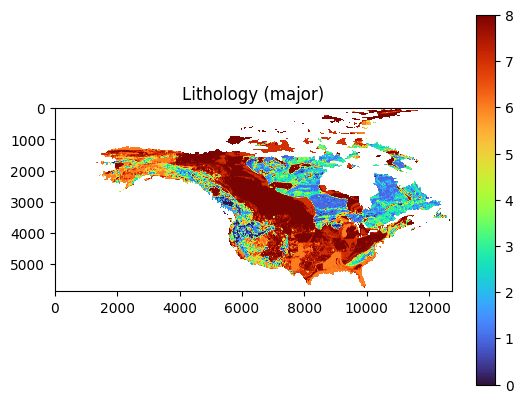

  4%|▍         | 1/26 [03:00<1:15:18, 180.74s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


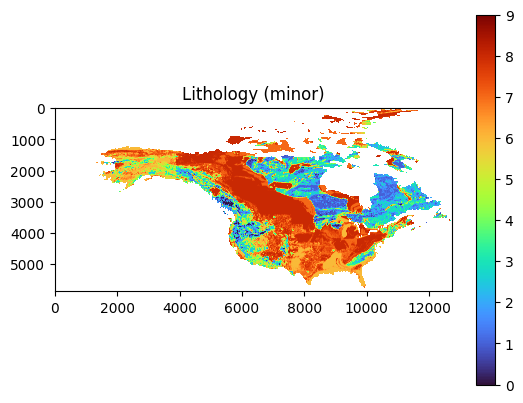

  8%|▊         | 2/26 [06:03<1:12:46, 181.95s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


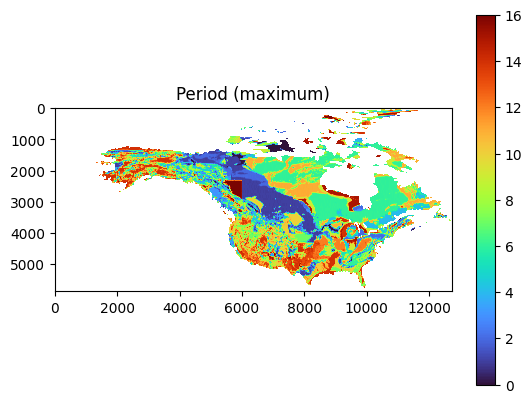

 12%|█▏        | 3/26 [09:04<1:09:37, 181.62s/it]/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category_col] = df[category_col].replace(categories_dict).astype("uint8")


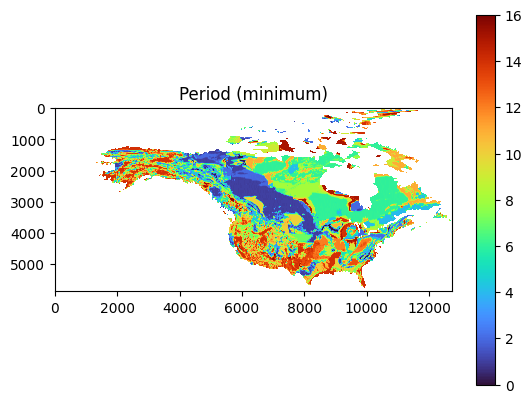

 15%|█▌        | 4/26 [12:07<1:06:43, 181.97s/it]

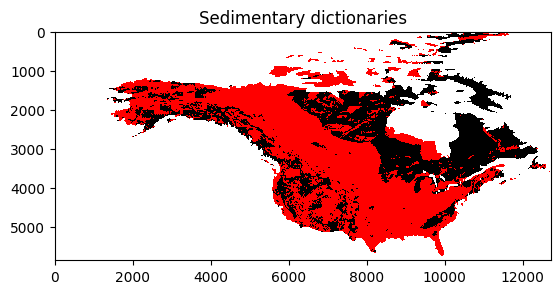

 19%|█▉        | 5/26 [15:04<1:03:06, 180.33s/it]

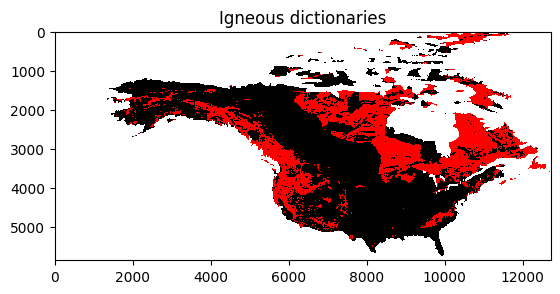

 23%|██▎       | 6/26 [18:04<1:00:01, 180.08s/it]

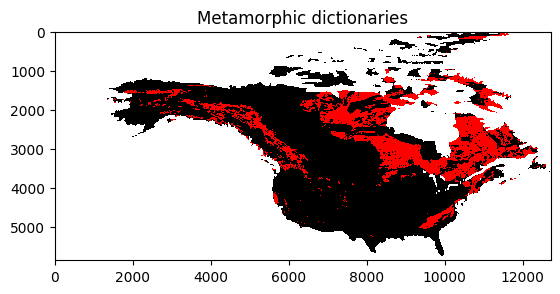

 27%|██▋       | 7/26 [21:02<56:48, 179.42s/it]  

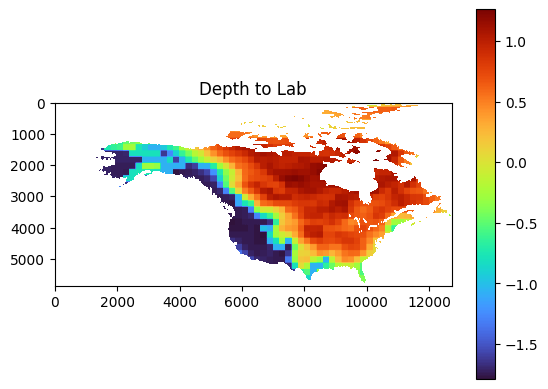

 31%|███       | 8/26 [24:01<53:45, 179.20s/it]

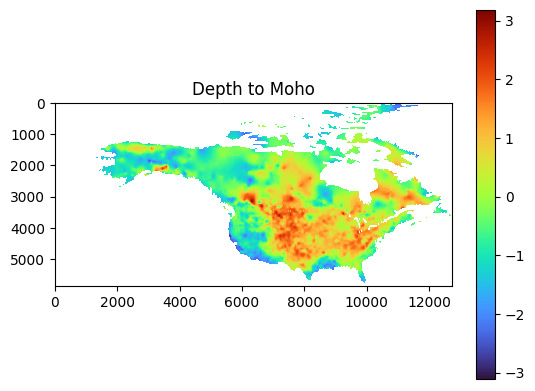

 35%|███▍      | 9/26 [27:01<50:55, 179.72s/it]

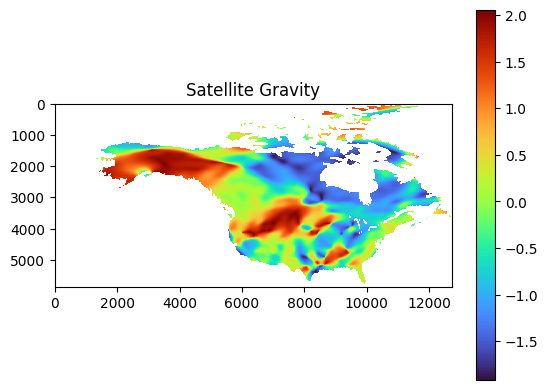

 38%|███▊      | 10/26 [30:00<47:48, 179.30s/it]

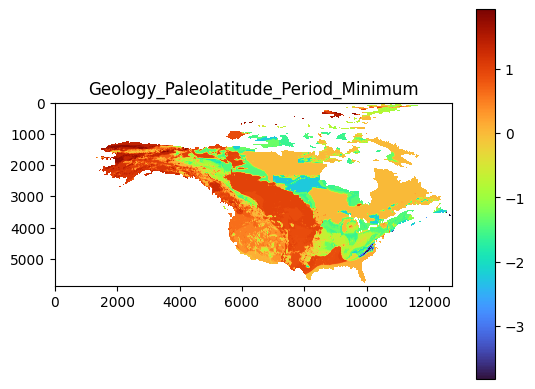

 42%|████▏     | 11/26 [32:58<44:45, 179.04s/it]

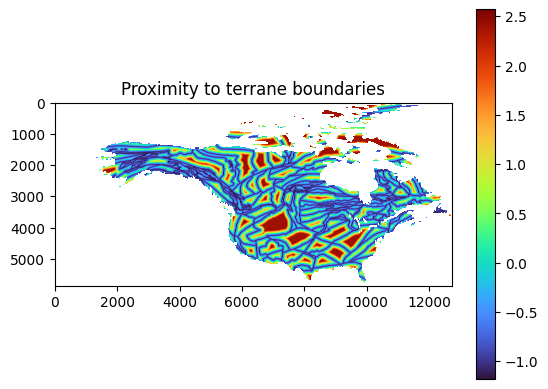

 46%|████▌     | 12/26 [35:58<41:50, 179.33s/it]

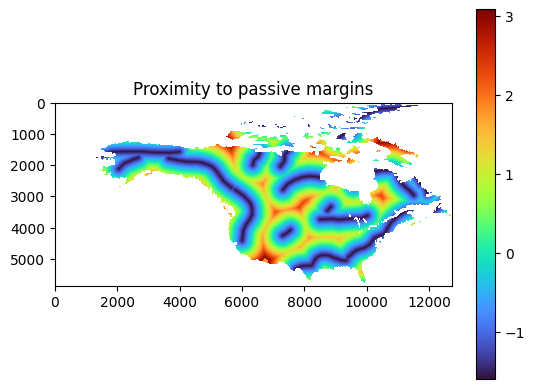

 50%|█████     | 13/26 [38:57<38:47, 179.05s/it]

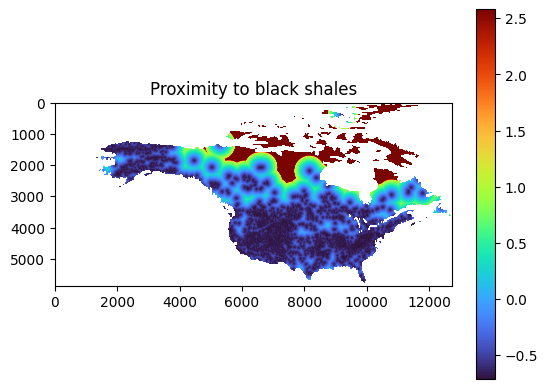

 54%|█████▍    | 14/26 [41:55<35:47, 178.99s/it]

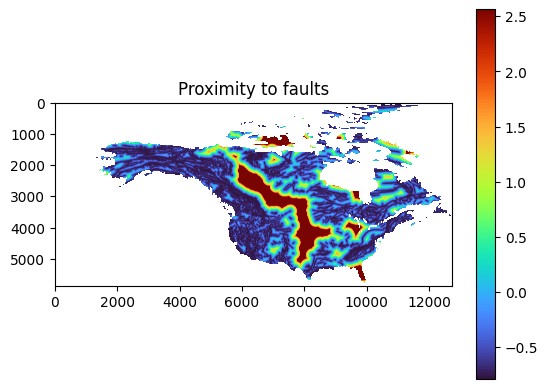

 58%|█████▊    | 15/26 [44:56<32:55, 179.58s/it]

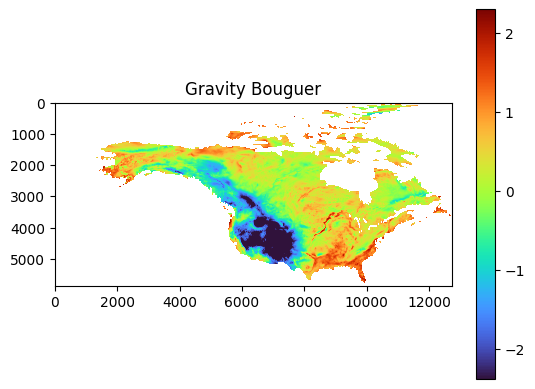

 62%|██████▏   | 16/26 [47:56<29:54, 179.47s/it]

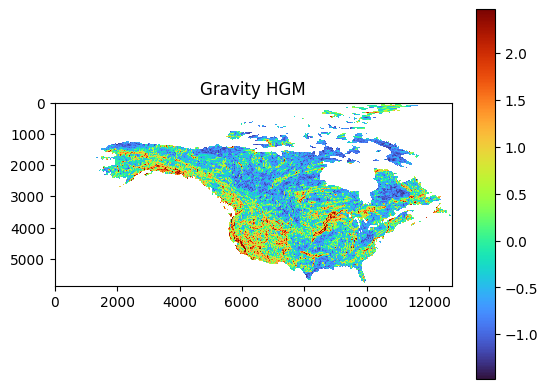

 65%|██████▌   | 17/26 [50:54<26:52, 179.17s/it]

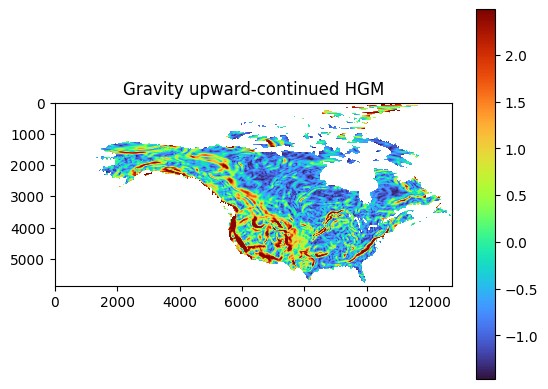

 69%|██████▉   | 18/26 [53:55<23:56, 179.58s/it]

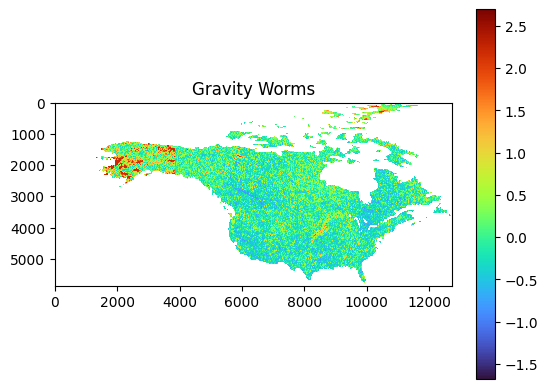

 73%|███████▎  | 19/26 [56:55<20:57, 179.66s/it]

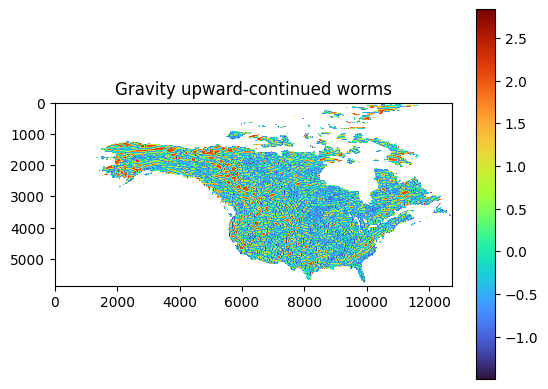

 77%|███████▋  | 20/26 [59:53<17:56, 179.46s/it]

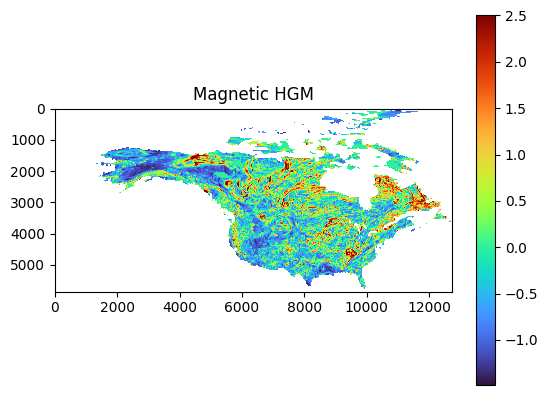

 81%|████████  | 21/26 [1:02:54<14:58, 179.77s/it]

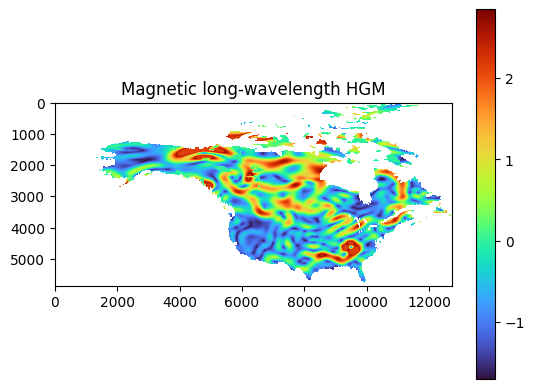

 85%|████████▍ | 22/26 [1:05:53<11:58, 179.56s/it]

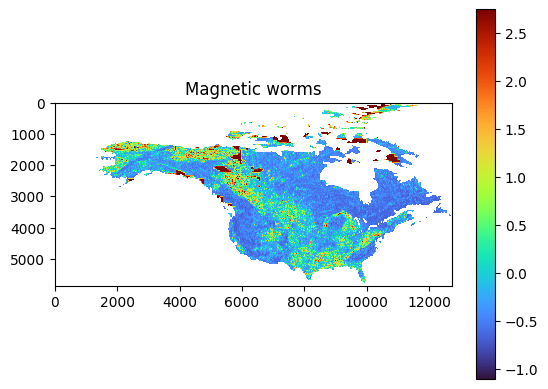

 88%|████████▊ | 23/26 [1:08:53<08:59, 179.82s/it]

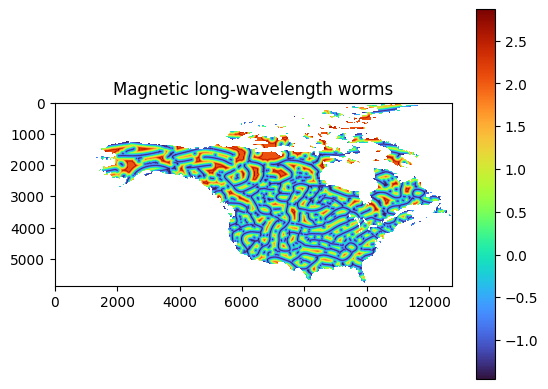

 92%|█████████▏| 24/26 [1:11:53<05:59, 179.77s/it]

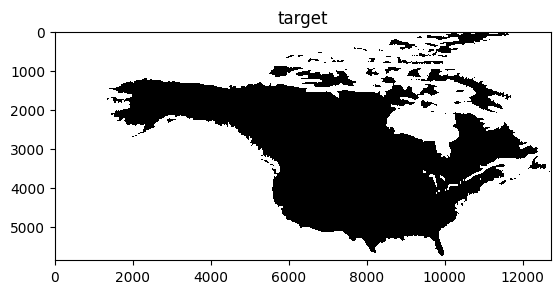

 96%|█████████▌| 25/26 [1:14:53<02:59, 179.71s/it]

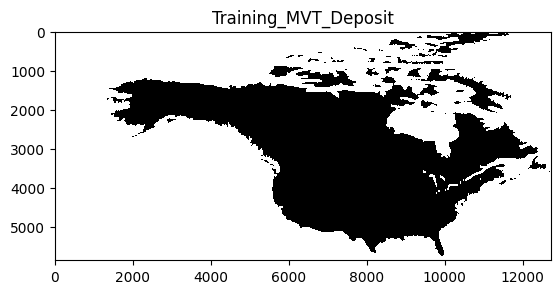

100%|██████████| 26/26 [1:17:52<00:00, 179.72s/it]


Outputting - ['Sedimentary dictionaries', 'Igneous dictionaries', 'Metamorphic dictionaries', 'Depth to Lab', 'Depth to Moho', 'Satellite Gravity', 'Geology_Paleolatitude_Period_Minimum', 'Proximity to terrane boundaries', 'Proximity to passive margins', 'Proximity to black shales', 'Proximity to faults', 'Gravity Bouguer', 'Gravity HGM', 'Gravity upward-continued HGM', 'Gravity Worms', 'Gravity upward-continued worms', 'Magnetic HGM', 'Magnetic long-wavelength HGM', 'Magnetic worms', 'Magnetic long-wavelength worms', 'Training_MVT_Deposit', 'Lithology (major)_0', 'Lithology (major)_1', 'Lithology (major)_2', 'Lithology (major)_3', 'Lithology (major)_4', 'Lithology (major)_5', 'Lithology (major)_6', 'Lithology (major)_7', 'Lithology (major)_8', 'Lithology (minor)_0', 'Lithology (minor)_1', 'Lithology (minor)_2', 'Lithology (minor)_3', 'Lithology (minor)_4', 'Lithology (minor)_5', 'Lithology (minor)_6', 'Lithology (minor)_7', 'Lithology (minor)_8', 'Lithology (minor)_9', 'Period (maximu

100%|██████████| 75/75 [3:42:37<00:00, 178.10s/it]  


In [19]:
# sets location for output raster(s)
output_dir = './data/lawley_rasters/'
makedirs(output_dir, exist_ok=True)

continents = {
    "Oceania": {'left':112.9, 'bottom':-43.6, 'right':153.6, 'top':-9.5},
    "North America": {'left':-179.8, 'bottom':24.5, 'right':-52.6, 'top':83.15}
}

resolution = (0.01, 0.01)

for idx, (continent, bounds) in enumerate(continents.items()):
    print(f"Rasterizing {continent}")
    continent_datacube = data_filtered[data_filtered["Continent_Majority"] == continent]

    continent_datacube["H3_Geometry"] = continent_datacube["H3_Geometry"].apply(wkt.loads)

    height = int((bounds["top"]-bounds["bottom"]) / resolution[0])
    width = int((bounds["right"]-bounds["left"]) / resolution[1])

    tif_tf = rasterio.transform.from_bounds(
        bounds["left"],
        bounds["bottom"],
        bounds["right"],
        bounds["top"],
        width,
        height
    )

    tiff_meta = {
        "driver": 'GTiff',
        "height": height,
        "width": width,
        "count": 1,
        "dtype": "float32",
        "crs": rasterio.CRS.from_epsg(4326),
        "transform": tif_tf,
        "nodata": np_nan,
        "compress": "lzw",
    }

    continent_datacube.rename({
        # geology
        "Geology_Lithology_Majority": "Lithology (major)",
        "Geology_Lithology_Minority": "Lithology (minor)",
        "Geology_Period_Maximum_Majority": "Period (maximum)",
        "Geology_Period_Minimum_Majority": "Period (minimum)",
        "Geology_Paleolatitude_Period_Maximum": "Paleo-latitude",
        "Terrane_Proximity": "Proximity to terrane boundaries",
        "Geology_PassiveMargin_Proximity": "Proximity to passive margins",
        "Geology_BlackShale_Proximity": "Proximity to black shales",
        "Geology_Fault_Proximity": "Proximity to faults",
        "Sedimentary_Dictionary": "Sedimentary dictionaries",
        "Igneous_Dictionary": "Igneous dictionaries",
        "Metamorphic_Dictionary": "Metamorphic dictionaries",
        # geophysics
        "Seismic_LAB_Priestley": "Depth to Lab",
        "Seismic_Moho": "Depth to Moho",
        "Gravity_GOCE_ShapeIndex": "Satellite Gravity",
        "Gravity_Bouguer": "Gravity Bouguer",
        "Gravity_Bouguer_HGM": "Gravity HGM",
        "Gravity_Bouguer_UpCont30km_HGM": "Gravity upward-continued HGM",
        "Gravity_Bouguer_HGM_Worms_Proximity": "Gravity Worms",
        "Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity": "Gravity upward-continued worms",
        "Magnetic_HGM": "Magnetic HGM",
        "Magnetic_LongWavelength_HGM": "Magnetic long-wavelength HGM",
        "Magnetic_HGM_Worms_Proximity": "Magnetic worms",
        "Magnetic_LongWavelength_HGM_Worms_Proximity": "Magnetic long-wavelength worms"
    }, axis=1, inplace=True)
    
    utils.visualize_datacube(continent_datacube, tiff_meta)

    continent_datacube = pd.get_dummies(
        continent_datacube, 
        columns=[
            'Lithology (major)',
            'Lithology (minor)',
            'Period (maximum)',
            'Period (minimum)'
        ], 
        prefix=[
            'Lithology (major)',
            'Lithology (minor)',
            'Period (maximum)',
            'Period (minimum)'
        ]
    )
    reorder_cols = [col for col in continent_datacube.columns if col != 'target'] + ['target']
    continent_datacube = continent_datacube[reorder_cols]

    utils.rasterize_datacube(continent_datacube, tiff_meta, output_dir, continent.lower().replace(" ","-"))